In [1]:
import yfinance as yf
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
from pyESN import ESN 

import RSI as rsi
import CPM as cpm
import importlib
import MovingAverage as ma
import Stochastic as st
importlib.reload(ma)
importlib.reload(cpm)
importlib.reload(st)
importlib.reload(rsi)

<module 'RSI' from 'C:\\Users\\jpran\\Capstone\\RSI.py'>

In [2]:
name = 'NEE' 
ticker = yf.Ticker(name)
ori_df = ticker.history(start='2015-07-22', end='2025-07-22', interval='1d', auto_adjust=False)

In [3]:
ori_df.isnull().sum()

Open            0
High            0
Low             0
Close           0
Adj Close       0
Volume          0
Dividends       0
Stock Splits    0
dtype: int64

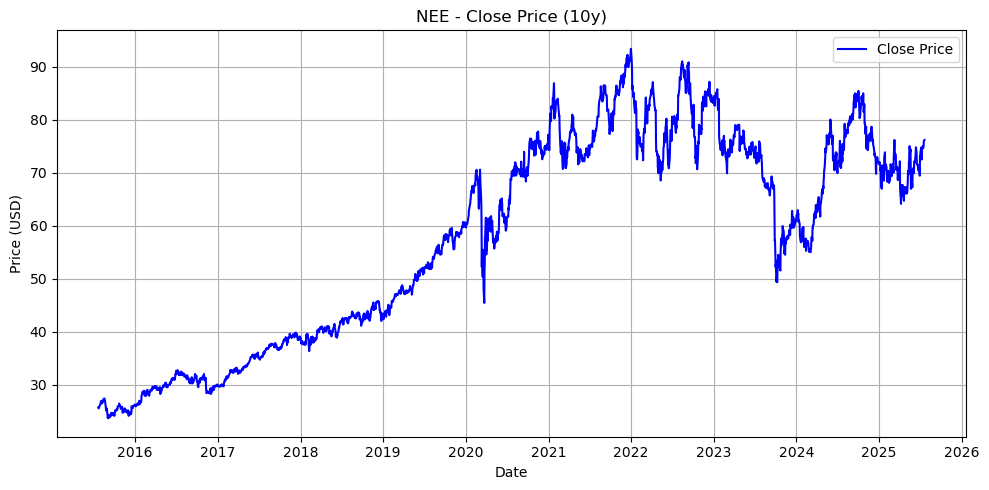

In [4]:
plt.figure(figsize=(10, 5))
plt.plot(ori_df.index, ori_df['Close'], label='Close Price', color='blue')
plt.title(f'{name} - Close Price (10y)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [5]:
df = ori_df.copy()

In [6]:
cpm_points, df_with_cpm = cpm.cpm_model(df, column='Close',P=0.09, T=5)

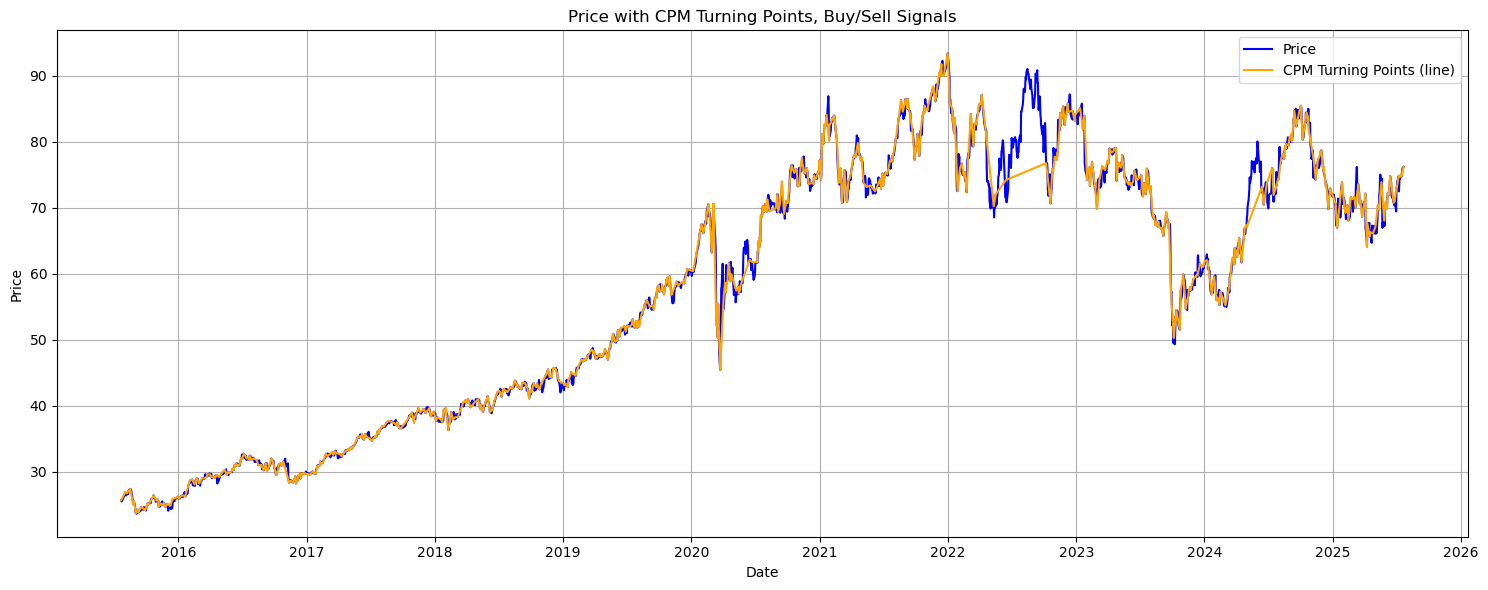

In [7]:
# CPM 신호가 있는 인덱스와 가격
cpm_indices = df_with_cpm[df_with_cpm['is_cpm_point'] == True].index
cpm_prices = df_with_cpm.loc[cpm_indices, 'Close']

# Buy (1) / Sell (-1) 인덱스와 가격
buy_indices = df_with_cpm[df_with_cpm['cpm_point_type'] == 1].index
sell_indices = df_with_cpm[df_with_cpm['cpm_point_type'] == -1].index
buy_prices = df_with_cpm.loc[buy_indices, 'Close']
sell_prices = df_with_cpm.loc[sell_indices, 'Close']

plt.figure(figsize=(15, 6))

# 1. 전체 가격 라인
plt.plot(df.index, df_with_cpm['Close'], label='Price', color='blue')

# 2. CPM 전환점을 선으로 연결
plt.plot(cpm_indices, cpm_prices, label='CPM Turning Points (line)', color='orange')

# 3. Buy 시점 (▲ 초록색)
#plt.scatter(buy_indices, buy_prices, label='Buy Signal', marker='^', color='green', s=100)

# 4. Sell 시점 (▼ 빨간색)
#plt.scatter(sell_indices, sell_prices, label='Sell Signal', marker='v', color='red', s=100)

plt.title("Price with CPM Turning Points, Buy/Sell Signals")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [8]:
if not isinstance(df_with_cpm.index, pd.DatetimeIndex):
    df_with_cpm.index = pd.to_datetime(df_with_cpm.index)
if df_with_cpm.index.tz is not None:
    df_with_cpm.index = df_with_cpm.index.tz_localize(None)
df_with_cpm.index = df_with_cpm.index.normalize()

In [9]:
total_len = len(df)

train_end = int(total_len * 0.8)
train_df = df_with_cpm.iloc[:train_end]
test_df = df_with_cpm.iloc[train_end:]

In [10]:
ma_best_params, ma_best_fitness, train_df = ma.run_MA_ga_optimization(train_df)

print("Best Parameters:", ma_best_params)
print("Best Fitness:", ma_best_fitness)

이동평균 유전 알고리즘 실행 중...
gen	nevals	avg    	min    	max   
0  	50    	474.537	449.542	489.74
1  	41    	inf    	443.365	inf   
2  	40    	inf    	443.835	inf   
3  	37    	inf    	436.405	inf   
4  	41    	inf    	436.405	inf   
5  	38    	463.801	436.405	485.73
6  	37    	462.775	448.658	507.005
7  	38    	459.176	446.23 	481.51 
8  	40    	inf    	446.685	inf    
9  	35    	455.977	438.17 	498.16 
10 	41    	450.355	424.722	475.845
11 	42    	447.098	434.687	470.86 
12 	40    	441.927	416.387	473.78 
13 	41    	438.902	417.787	462.782
14 	37    	436.274	413.405	463.45 
15 	38    	432.33 	413.677	454.425
16 	39    	427.315	413.677	452.63 
17 	40    	424.648	407.03 	443.775
18 	39    	420.679	407.03 	464.075
19 	36    	421.844	407.03 	473.555
20 	35    	419.114	407.03 	441.86 
21 	38    	414.878	407.03 	430.38 
22 	38    	413.97 	407.03 	434.57 
23 	43    	412.093	407.03 	435.34 
24 	39    	409.432	407.03 	437.26 
25 	39    	407.193	407.03 	414.19 
26 	39    	407.636	406.362	421.392
27 	44

In [11]:
N, n, a, b, c = ma_best_params

In [12]:
test_ma_signals = ma.generate_MA_signals(test_df, N, n, a, b, c)

빈 데이터프레임 반환


In [13]:
signal_map = test_ma_signals.set_index('Index')['Type'].map({'BUY': -1, 'SELL': 1})
test_df['MA_Signals'] = signal_map.reindex(test_df.index).fillna(0).astype(int)

C:\Users\jpran\AppData\Local\Temp\ipykernel_6312\4009268628.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['MA_Signals'] = signal_map.reindex(test_df.index).fillna(0).astype(int)


In [14]:
rsi_best_params, rsi_best_fitness, train_df = rsi.run_RSI_ga_optimization(train_df)

print("Best Parameters:", ma_best_params)
print("Best Fitness:", ma_best_fitness)

RSI 유전 알고리즘 실행 중...
gen	nevals	avg    	min    	max    
0  	50    	473.591	471.973	473.653
1  	44    	inf    	471.198	inf    
2  	35    	inf    	470.333	inf    
3  	44    	inf    	467.298	inf    
4  	40    	inf    	467.298	inf    
5  	35    	inf    	470.333	inf    
6  	37    	inf    	468.568	inf    
7  	35    	inf    	468.373	inf    
8  	41    	inf    	466.63 	inf    
9  	45    	471.564	468.373	474.385
10 	43    	inf    	465.023	inf    
11 	41    	inf    	465.373	inf    
12 	44    	469.603	464.173	473.653
13 	30    	468.108	464.173	471.215
14 	37    	inf    	464.173	inf    
15 	36    	inf    	461.723	inf    
16 	34    	inf    	460.253	inf    
17 	36    	inf    	460.253	inf    
18 	28    	inf    	459.788	inf    
19 	38    	463.079	459.788	467.985
20 	42    	463.332	459.788	469.378
21 	38    	462.327	459.788	470.113
22 	31    	461.48 	459.788	465.228
23 	42    	461.918	459.593	471.258
24 	42    	460.716	459.593	464.173
25 	38    	460.635	459.593	464.173
26 	41    	460.689	459.593	464.855


In [15]:
x, overbought_level, oversold_level, p, q = rsi_best_params

In [16]:
test_rsi_signals = rsi.generate_RSI_signals(test_df, x, overbought_level, oversold_level, p, q)

503 5.039559487851474


In [17]:
signal_map = test_rsi_signals.set_index('Index')['Type'].map({'BUY': -1, 'SELL': 1})
test_df['RSI_Signals'] = signal_map.reindex(test_df.index).fillna(0).astype(int)

C:\Users\jpran\AppData\Local\Temp\ipykernel_6312\1229919477.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['RSI_Signals'] = signal_map.reindex(test_df.index).fillna(0).astype(int)


In [18]:
Technical_Signals = ['MA_Signals', 'RSI_Signals']

In [19]:
import ESN_GA
from ESN_GA import run_genetic_algorithm, perform_final_backtest, PARAM_RANGES
importlib.reload(ESN_GA)

C:\Users\jpran\AppData\Roaming\Python\Python312\site-packages\backtesting\_plotting.py:55: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support, such as old IDEs. Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

<module 'ESN_GA' from 'C:\\Users\\jpran\\Capstone\\ESN_GA.py'>

In [20]:
best_params_ga, ga_log = run_genetic_algorithm(
    train_df_ga=train_df,
    test_df_ga=test_df,
    technical_signals_list=Technical_Signals,
    pop_size=30,
    num_generations=15,
    random_seed=42
)

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

gen	nevals	avg    	std    	min     	max   
0  	30    	-12.831	25.1732	-63.8316	27.523


Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

1  	25    	-11.3053	22.3735	-57.4407	27.523


Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

2  	23    	-8.27769	21.6486	-64.9282	27.523


Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

3  	28    	-6.06656	31.0084	-68.2665	30.3069


Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

4  	27    	6.52411 	22.3931	-71.7082	38.1186


Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

5  	19    	13.1507 	16.6276	-17.4477	51.3199


Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

6  	21    	14.7683 	18.2756	-6.46643	51.3199


Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

7  	30    	9.23489 	14.9299	-35.0578	35.7389


Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

8  	21    	10.9552 	16.7551	-30.3147	35.7389


Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

9  	27    	13.9159 	14.5775	-10.8717	40.4709


Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

10 	25    	16.9925 	15.4266	-8.36158	40.4709


Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

11 	20    	24.0425 	16.2543	-15.8226	40.4709


Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

12 	23    	22.7989 	20.671 	-25.7967	40.4709


Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

13 	22    	31.0415 	13.7153	-11.2265	40.4709


Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

14 	25    	31.7203 	17.3753	-15.8775	40.4709


Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

15 	22    	39.2878 	6.37102	4.97879 	40.4709

GA 최적화 완료 - 최적 하이퍼파라미터: [362.25106971716804, 1.2404485825595701, 0.35345696835435664, 0.7128224173754659]
GA 최적화 완료 - 최고 Return [%]: 51.3199


In [21]:
print(best_params_ga)

[362.25106971716804, 1.2404485825595701, 0.35345696835435664, 0.7128224173754659]


In [22]:
final_backtest_stats, final_signals = perform_final_backtest(
    train_df=train_df,
    test_df=test_df,
    best_params=best_params_ga,
    technical_signals_list=Technical_Signals,
    random_state=42
)


--- 최적화된 파라미터로 최종 ESN 학습 및 백테스팅 ---
  n_reservoir: 362
  spectral_radius: 1.2404
  sparsity: 0.3535
  signal_threshold: 0.7128


Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]


최종 백테스팅 결과 (최적화된 파라미터):
Start                     2023-07-19 00:00:00
End                       2025-07-21 00:00:00
Duration                    733 days 00:00:00
Exposure Time [%]                     16.6998
Equity Final [$]                  15131.98506
Equity Peak [$]                   16965.46548
Commissions [$]                     270.64954
Return [%]                           51.31985
Buy & Hold Return [%]                 5.64494
Return (Ann.) [%]                     23.0628
Volatility (Ann.) [%]                31.60583
CAGR [%]                             15.30467
Sharpe Ratio                           0.7297
Sortino Ratio                          1.3064
Calmar Ratio                          0.92688
Alpha [%]                            47.09497
Beta                                  0.74844
Max. Drawdown [%]                   -24.88208
Avg. Drawdown [%]                    -4.11059
Max. Drawdown Duration      292 days 00:00:00
Avg. Drawdown Duration       34 days 00:00:00
# Trades 

In [23]:
def plot_signals(original_df: pd.DataFrame, signals_df: pd.DataFrame, title: str = "ESN Signals with CPM Points"):
    plt.figure(figsize=(16, 8))
    plt.plot(original_df.index, original_df['Close'], label='Close Price', color='skyblue', linewidth=1.5)

    # ESN 예측 매수 신호 (BUY) 표시
    buy_signals = signals_df[signals_df['Predicted_Signals'] == -1]
    plt.scatter(buy_signals.index, buy_signals['Close'],
                marker='^', color='green', s=100, label='ESN BUY Signal', alpha=0.8, zorder=5)

    # ESN 예측 매도 신호 (SELL) 표시
    sell_signals = signals_df[signals_df['Predicted_Signals'] == 1]
    plt.scatter(sell_signals.index, sell_signals['Close'],
                marker='v', color='red', s=100, label='ESN SELL Signal', alpha=0.8, zorder=5)

    # --- CPM Point Type ---
    if 'cpm_point_type' in original_df.columns:
        cpm_buy_points = original_df[original_df['cpm_point_type'] == -1]
        cpm_sell_points = original_df[original_df['cpm_point_type'] == 1]

        # CPM BUY 포인트
        plt.scatter(cpm_buy_points.index, cpm_buy_points['Close'],
                    marker='D', color='blue', s=120, label='CPM BUY Point', alpha=0.6, zorder=4)

        # CPM SELL 포인트
        plt.scatter(cpm_sell_points.index, cpm_sell_points['Close'],
                    marker='D', color='orange', s=120, label='CPM SELL Point', alpha=0.6, zorder=4)
    else:
        print("경고: 'cpm_point_type' 컬럼이 original_df에 없어 CPM 포인트를 표시할 수 없습니다.")

    plt.title(title, fontsize=16)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Close Price', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

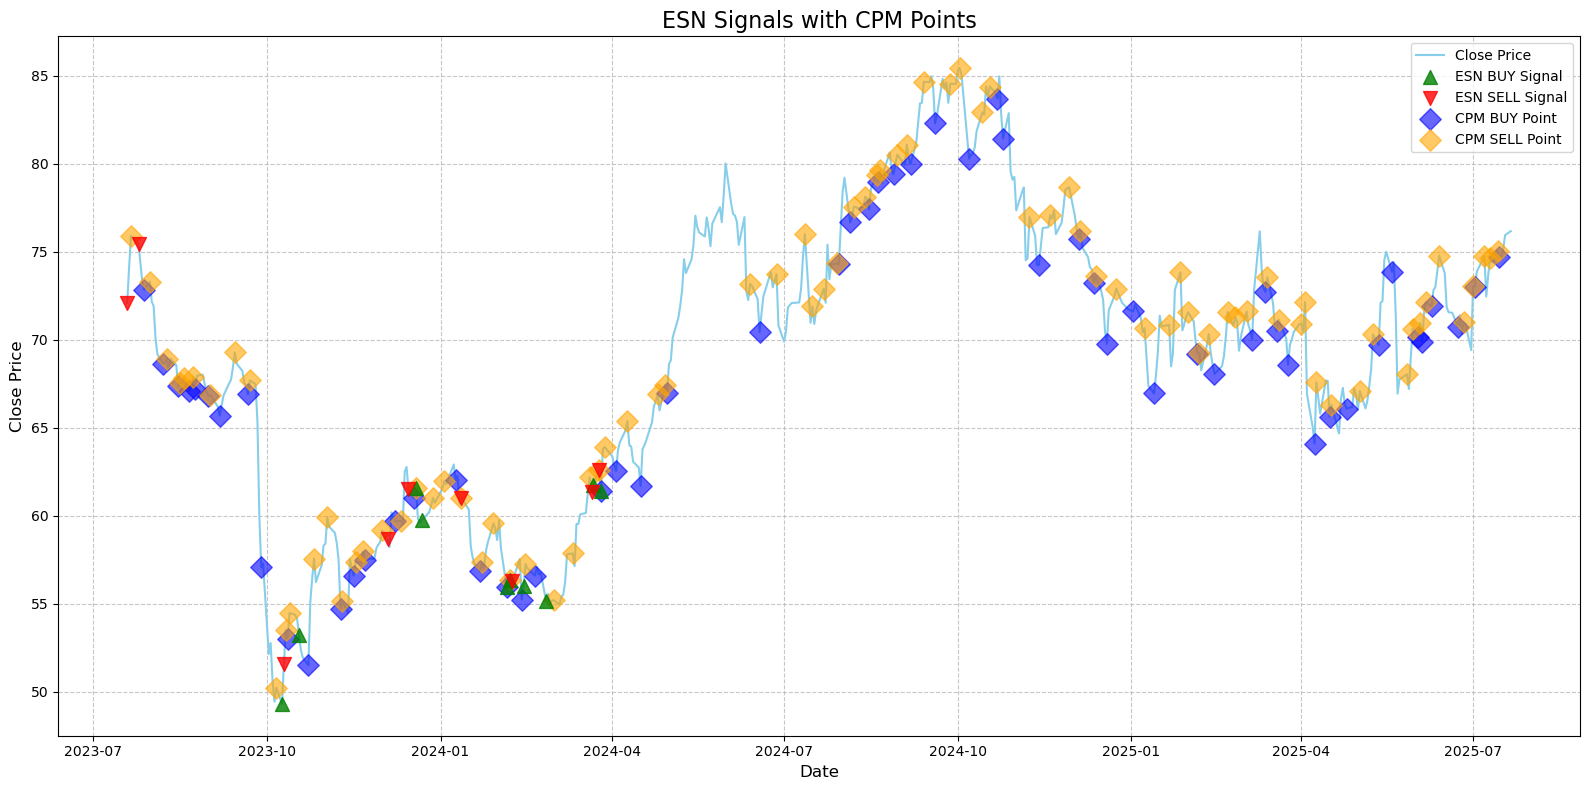

In [24]:
plot_signals(test_df, final_signals)